In [38]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

https://www.youtube.com/watch?v=1-NYPQw5THU&feature=youtu.be

In [40]:
import pandas as pd
import numpy as np
import datetime
from pandas_summary import DataFrameSummary

In [41]:
df = pd.read_feather('train_normalized_data.fth')
df_test = pd.read_feather('test_normalized_data.fth')

In [42]:
df.columns

Index(['index', 'Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open',
       'Promo', 'StateHoliday', 'SchoolHoliday', 'Year', 'Month', 'Week',
       'Day', 'StoreType', 'Assortment', 'CompetitionDistance',
       'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2',
       'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval',
       'CompetitionOpenSince', 'Promo2Since', 'State', 'file', 'week', 'trend',
       'Date_y', 'Month_y', 'Day_y', 'file_DE', 'week_DE', 'trend_DE',
       'Date_DE', 'State_DE', 'Month_DE', 'Day_DE', 'file_y',
       'Max_TemperatureC', 'Mean_TemperatureC', 'Min_TemperatureC',
       'Dew_PointC', 'MeanDew_PointC', 'Min_DewpointC', 'Max_Humidity',
       'Mean_Humidity', 'Min_Humidity', 'Max_Sea_Level_PressurehPa',
       'Mean_Sea_Level_PressurehPa', 'Min_Sea_Level_PressurehPa',
       'Max_VisibilityKm', 'Mean_VisibilityKm', 'Min_VisibilitykM',
       'Max_Wind_SpeedKm_h', 'Mean_Wind_SpeedKm_h', 'Max_Gust_SpeedKm_h',
       'Precipitatio

In [43]:
cat_vars = ['Store', 'DayOfWeek', 'Year', 'Month', 'Day', 'StateHoliday', 'CompetitionMonthsOpen', 'Promo2Weeks', 
            'StoreType', 'Assortment', 'PromoInterval', 'CompetitionOpenSinceYear', 'Promo2SinceYear', 'State', 
            'Week', 'Events', 'Promo_fw', 'Promo_bw', 'StateHoliday_bool_fw', 'StateHoliday_bool_bw', 'SchoolHoliday_fw', 'SchoolHoliday_bw']

# cat_vars = ['Store', 'DayOfWeek', 'Year', 'Month', 'Day', 'State']


In [44]:
contin_vars = ['CompetitionDistance', 
   'Max_TemperatureC', 'Mean_TemperatureC', 'Min_TemperatureC',
   'Max_Humidity', 'Mean_Humidity', 'Min_Humidity', 'Max_Wind_SpeedKm_h', 
   'Mean_Wind_SpeedKm_h', 'CloudCover', 'trend', 'trend_DE',
   'AfterStateHoliday_bool', 'BeforeStateHoliday_bool', 'Promo', 'SchoolHoliday']
# contin_vars = []

In [45]:
from lightgbm import LGBMRegressor

In [130]:
import lightgbm as lgb

In [46]:
y_out_columns = ['Sales']

In [47]:
# split_type = 'random'
# split_type = 'no_split'
split_type = 'last_week'

In [48]:
# Esta es para entrenar con todo
if split_type == 'no_split':
    df_train = df
elif split_type == 'last_week':
    # Esto divide en train y val
    df_train = df[df.Date < datetime.datetime(2015, 7, 1)]  
    df_val = df[df.Date >= datetime.datetime(2015, 7, 1)]
    print(f'Cantidad en val: {len(df_val)}, porcentaje: {len(df_train)/(len(df_train) + len(df_val))}')
elif split_type == 'random':
    # Splitting aleatorio
    np.random.seed(42)
    indexes = np.arange(len(df))
    np.random.shuffle(indexes)
    N = len(df)//5
    df_train = df[N:]
    df_val = df[:N]
    print(f'Cantidad en val: {len(df_val)}, porcentaje: {len(df_train)/(len(df_train) + len(df_val))}')

Cantidad en val: 30188, porcentaje: 0.9642465458145908


In [49]:
X_train = df_train[cat_vars + contin_vars]
if split_type != 'no_split':
    X_val = df_val[cat_vars + contin_vars]
X_test = df_test[cat_vars + contin_vars]

In [50]:
log_output = False
    
if log_output:
    # Escala logaritmica
    max_log_y = np.max(np.log(df[y_out_columns])).values
    y_train = np.log(df_train[y_out_columns].values)/max_log_y
    if split_type != 'no_split':
        y_val = np.log(df_val[y_out_columns].values)/max_log_y
else:
    # Normalización
    y_mean = df_train[y_out_columns].mean().values
    y_std = df_train[y_out_columns].std().values
    y_train = (df_train[y_out_columns].values - y_mean)/y_std
    if split_type != 'no_split':
        y_val = (df_val[y_out_columns].values - y_mean)/y_std

In [51]:
from sklearn.model_selection import cross_val_score
from hyperopt import hp, tpe
from hyperopt.fmin import fmin

In [52]:
def calculate_RMSE(X, y, log_output=True):
    y_preds = np.exp(model.predict(X, verbose=1)*max_log_y)
    return np.sqrt((((y - y_preds)/y)**2).sum()/len(y_preds))

In [53]:
X_train.shape

(814150, 38)

In [103]:
def objective(params):
    params = {
#         'max_depth': int(params['max_depth']),
         'colsample_bytree': '{:.3f}'.format(params['colsample_bytree']),
         'learning_rate': '{:.4f}'.format(params['learning_rate'])
    }
    
    clf = LGBMRegressor(
        n_estimators=4000,
        min_child_samples= 5, max_depth= -1,
        **params
    )
    
    score = -cross_val_score(clf, X_train.values, y_train.reshape(-1)).mean()
    return score

In [123]:
space = {
     'max_depth': hp.quniform('max_depth', 1, 6, 10),
     'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1.0),
    'learning_rate': hp.uniform('learning_rate', 0.1, 0.5)
}



In [124]:
best = fmin(fn=objective,
            space=space,
            verbose=2,
            algo=tpe.suggest,
            max_evals=10)

100%|████████████████████████████████████████████| 10/10 [1:20:54<00:00, 485.48s/trial, best loss: -0.8988960454219062]


In [125]:
best

{'colsample_bytree': 0.939687352268927,
 'learning_rate': 0.14599963145488648,
 'max_depth': 0.0}

In [133]:
from sklearn.model_selection import RandomizedSearchCV

In [ ]:
#grid of parameters
gridParams = {
    'learning_rate': [0.05,0.1,0.15],
    'num_leaves': [100,200],
    'boosting_type' : ['gbdt'],
    'objective' : ['regression'],
    'max_depth' : [5,6,7,8],
    'random_state' : [42], 
    'colsample_bytree' : [1],
    'n_estimators' :[4000],
    'subsample' : [0.5,0.7],
    'min_child_samples': [5,15],
    'min_split_gain' : [0.01],
    'min_data_in_leaf':[10],
    'metric':['mean_squared_error'],
    'vervose':[1]
    }

In [161]:
#modelling
#clf = lgb.LGBMRegressor()
grid = RandomizedSearchCV(LGBMRegressor(),gridParams,verbose=1,cv=5,n_jobs = -1,n_iter=10)

In [162]:
grid.fit(X_train, y_train.reshape(-1))

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=5 will be ignored. Current value: min_data_in_leaf=10


RandomizedSearchCV(cv=5, estimator=LGBMRegressor(), n_jobs=-1,
                   param_distributions={'boosting_type': ['gbdt'],
                                        'colsample_bytree': [1],
                                        'learning_rate': [0.05, 0.1, 0.15],
                                        'max_depth': [5, 6, 7, 8],
                                        'metric': ['mean_squared_error'],
                                        'min_child_samples': [5, 15],
                                        'min_data_in_leaf': [10],
                                        'min_split_gain': [0.01],
                                        'n_estimators': [4000],
                                        'num_leaves': [100, 200],
                                        'objective': ['regression'],
                                        'random_state': [42],
                                        'subsample': [0.5, 0.7]},
                   verbose=1)

In [163]:
#best parameters
grid.best_params_

{'subsample': 0.5,
 'random_state': 42,
 'objective': 'regression',
 'num_leaves': 200,
 'n_estimators': 4000,
 'min_split_gain': 0.01,
 'min_data_in_leaf': 10,
 'min_child_samples': 5,
 'metric': 'mean_squared_error',
 'max_depth': 7,
 'learning_rate': 0.1,
 'colsample_bytree': 1,
 'boosting_type': 'gbdt'}

In [175]:
modelos_lgbm = pd.DataFrame(grid.cv_results_)
modelos_lgbm = modelos_lgbm.sort_values('rank_test_score',ascending=True).head()
modelos_lgbm.head(4)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_subsample,param_random_state,param_objective,param_num_leaves,param_n_estimators,param_min_split_gain,...,param_boosting_type,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
4,460.151798,84.300888,151.217905,4.887613,0.5,42,regression,200,4000,0.01,...,gbdt,"{'subsample': 0.5, 'random_state': 42, 'object...",0.877083,0.896291,0.889667,0.901261,0.885391,0.889939,0.008421,1
3,616.009994,106.118527,335.193155,3.575910,0.5,42,regression,100,4000,0.01,...,gbdt,"{'subsample': 0.5, 'random_state': 42, 'object...",0.874897,0.896701,0.887346,0.900145,0.877557,0.887329,0.010021,2
7,3410.507066,120.851587,358.562093,8.374961,0.7,42,regression,200,4000,0.01,...,gbdt,"{'subsample': 0.7, 'random_state': 42, 'object...",0.874897,0.896701,0.887346,0.900145,0.877557,0.887329,0.010021,2
9,610.230294,83.623767,275.655390,36.950181,0.7,42,regression,100,4000,0.01,...,gbdt,"{'subsample': 0.7, 'random_state': 42, 'object...",0.874897,0.896701,0.887346,0.900145,0.877557,0.887329,0.010021,2


In [167]:
#Prediction
y_pred = grid.predict(X_test)

In [140]:
import matplotlib as plt

<AxesSubplot:title={'center':'Feature Importance'}>

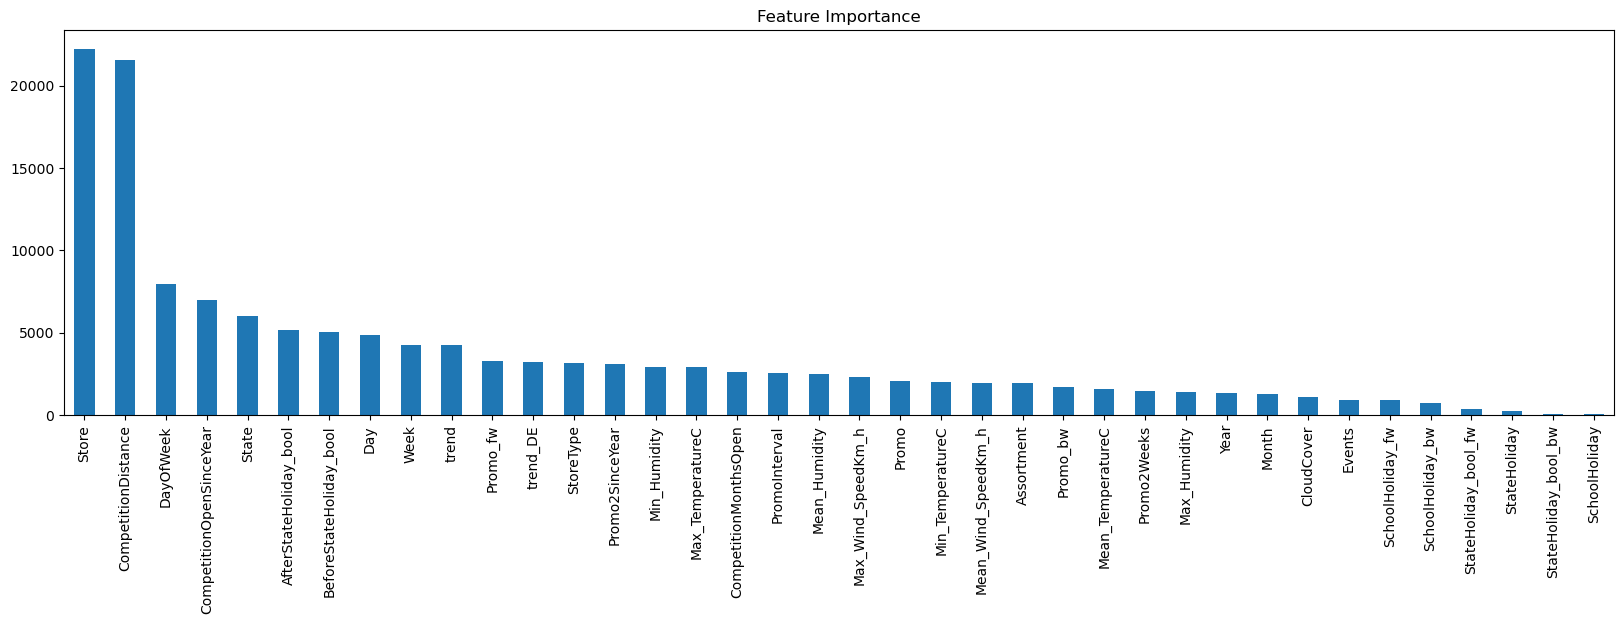

In [168]:
#Feature importance for top 50 predictors
predictors = [x for x in X_train.columns]
feat_imp = pd.Series(grid.best_estimator_.feature_importances_, predictors).sort_values(ascending=False)
feat_imp = feat_imp[0:50]
plt.rcParams['figure.figsize'] = 20, 5
feat_imp.plot(kind='bar', title='Feature Importance')
#plt.ylabel('Feature Importance Score')

In [169]:
grid.best_score_

0.8899386152230513

In [ ]:
#submission
predictions = grid.predict(test.drop(["ID_code","target"],axis=1))
sub_df = pd.DataFrame({"ID_code":test["ID_code"].values})
sub_df["target"] = predictions
sub_df.to_csv("submission.csv", index=False)

In [115]:
min_child_samples = 5
n_estimators = 4000
learning_rate = 0.025
model = LGBMRegressor(n_estimators=n_estimators, **grid_search_res_2)

In [111]:
clf = GridSearchCV(model, parameters, n_jobs=-1, verbose=1, cv=3)

In [112]:
fit_params={ "eval_metric" : 'l2', 
            'verbose': 100,
            'feature_name': 'auto', # that's actually the default
            'categorical_feature': cat_vars}
if split_type != 'no_split':
    fit_params["eval_set"] = [(X_val, y_val.reshape(-1))]
    fit_params["early_stopping_rounds"] = 100

In [116]:
# clf.fit(X_train, y_train.reshape(-1), **fit_params)
model.fit(X_train, y_train.reshape(-1), **fit_params)

C:\Users\HP\anaconda3\envs\rossmann\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\HP\anaconda3\envs\rossmann\lib\site-packages\lightgbm\basic.py:1706: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['Assortment', 'CompetitionMonthsOpen', 'CompetitionOpenSinceYear', 'Day', 'DayOfWeek', 'Events', 'Month', 'Promo2SinceYear', 'Promo2Weeks', 'PromoInterval', 'Promo_bw', 'Promo_fw', 'SchoolHoliday_bw', 'SchoolHoliday_fw', 'State', 'StateHoliday', 'StateHoliday_bool_bw', 'StateHoliday_bool_fw', 'Store', 'StoreType', 'Week', 'Year']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


LightGBMError: Parameter min_data_in_leaf should be of type int, got "5,10,20"

In [26]:
clf

GridSearchCV(cv=3,
             estimator=LGBMRegressor(learning_rate=0.05, max_depth=7,
                                     n_estimators=4000),
             n_jobs=-1,
             param_grid={'learning_rate': [0.001, 0.05, 0.1, 0.5],
                         'max_depth': [1, 7, 31, 63]},
             verbose=1)

In [27]:
clf.best_params_

AttributeError: 'GridSearchCV' object has no attribute 'best_params_'

In [143]:
clf.best_score_

NotFittedError: No best_score found. Need to call fit beforehand.

# Métrica

$$
\textrm{RMSE} = \sqrt{\frac{1}{n} \sum_{i=1}^{n} \left(\frac{\hat{y}_i - y_i}{y_i}\right)^2}
$$

In [172]:
model.score(X_val, y_val)

In [29]:
if log_output:
    y_pred_train = np.exp(model.predict(X_train, verbose=1)*max_log_y)
    y_pred = np.exp(model.predict(X_val, verbose=1)*max_log_y)
    y_pred_test = np.exp(model.predict(X_test, verbose=1)*max_log_y)
else:
    y_pred_train = model.predict(X_train, verbose=1)*y_std + y_mean
    y_pred = model.predict(X_val, verbose=1)*y_std + y_mean
    y_pred_test = model.predict(X_test, verbose=1)*y_std + y_mean

In [30]:
# Train
np.sqrt((((df_train['Sales'].values - y_pred_train)/df_train['Sales'].values)**2).sum()/len(y_pred_train))

0.1068625258147758

In [31]:
# Validación
np.sqrt((((df_val['Sales'].values - y_pred)/df_val['Sales'].values)**2).sum()/len(y_pred))

0.12346607713489312

In [32]:
calculate_RMSE(X_train, df_train['Sales'].values)

0.1068625258147758

In [33]:
calculate_RMSE(X_val, df_val['Sales'].values)

0.12346607713489312

# Sumbit a la competición

In [173]:
sample_csv = pd.read_csv('dataset/rossmann/sample_submission.csv')
sample_csv['Sales'] = y_pred_test
sample_csv.head()

sample_csv.to_csv(f'submision_lightgbmopt_{split_type}-{log_output}-{n_estimators}-{learning_rate}.csv', index=False)